# Convert the binary and categorical feature space
- Fuse categoricies for each feature into smaller number of categories based on conditional probabilities
- Calculate how much edge each category value has over the bulk frequency of class1
- Replace the category value with those ratios to inflate the differeces in conditional probabilities

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

from importlib import reload
from matplotlib import cm
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import (make_scorer, roc_auc_score, 
                             classification_report, 
                             precision_recall_curve,
                             roc_curve)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from feature_processing import (create_contingency_table,
                                calculate_conditional_prob_bin,
                                encode_my_categorical_labels,
                                calculate_conditional_prob_cat,
                                estimate_cond_prob_density,
                                bin_myFeature)
import feature_analysis as fa
import porto_seguro as ps

/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def my_gini(y_true, y_probas):
    auc = roc_auc_score(y_true, y_probas[:, 1])
    gini = 2*auc - 1
    return gini

gini_scorer = make_scorer(my_gini, needs_proba=True, greater_is_better=True)

In [3]:
train = pd.read_csv('train.csv', header=0)

all_fs = train.columns[:-1]
binary_fs = sorted([f for f in all_fs if '_bin' in f])
categorical_fs = sorted([f for f in all_fs if '_cat' in f])
other_fs = sorted([f for f in all_fs
            if f not in binary_fs
            if f not in categorical_fs])

binaries = train[binary_fs]
categoricals = train[categorical_fs]
others = train[other_fs[1:-1]]

new_categoricals = ps.fuseCategoricalFeatures(categoricals)

bincats = pd.concat([binaries, new_categoricals], axis=1)
target = train.target

In [4]:
others.columns

Index(['ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05',
       'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10',
       'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_ind_01',
       'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02',
       'ps_reg_03'],
      dtype='object')

In [5]:
reload(ps)

<module 'porto_seguro' from '/home/ryohayama/python_current/porto_seguro/porto_seguro.py'>

<b>Conditional Probas</b>

In [6]:
for i, f in enumerate(bincats.columns):
    fvt = fa.FeatureVsTarget(bincats[f], target)
    print('==== %s ====' % f)
    print(fvt.conditional_probas_)
    print('\n')

==== ps_calc_15_bin ====
target                 0         1
ps_calc_15_bin                    
0               0.963518  0.036482
1               0.963799  0.036201


==== ps_calc_16_bin ====
target         0         1
0       0.963704  0.036296
1       0.963462  0.036538


==== ps_calc_17_bin ====
target         0         1
0       0.963517  0.036483
1       0.963581  0.036419


==== ps_calc_18_bin ====
target                 0         1
ps_calc_18_bin                    
0               0.963618  0.036382
1               0.963389  0.036611


==== ps_calc_19_bin ====
target                 0         1
ps_calc_19_bin                    
0               0.963313  0.036687
1               0.963999  0.036001


==== ps_ind_06_bin ====
target                0         1
ps_ind_06_bin                    
0              0.958415  0.041585
1              0.971463  0.028537


==== ps_ind_07_bin ====
target                0         1
ps_ind_07_bin                    
0              0.967324  0.03

<b>Deviations</b>

In [7]:
for i, f in enumerate(bincats.columns):
    fvt = fa.FeatureVsTarget(bincats[f], target)
    print('==== %s ====' % f)
    print(100*(fvt.calculate_deviation(mode='ratio')[0] - 1))
    print('\n')

==== ps_calc_15_bin ====
target                 0         1
ps_calc_15_bin                    
0              -0.003563  0.094183
1               0.025537 -0.675117


==== ps_calc_16_bin ====
target         0         1
0       0.015759 -0.416609
1      -0.009341  0.246950


==== ps_calc_17_bin ====
target         0         1
0      -0.003689  0.097528
1       0.002968 -0.078457


==== ps_calc_18_bin ====
target                 0         1
ps_calc_18_bin                    
0               0.006820 -0.180291
1              -0.016927  0.447503


==== ps_calc_19_bin ====
target                 0         1
ps_calc_19_bin                    
0              -0.024834  0.656528
1               0.046319 -1.224514


==== ps_ind_06_bin ====
target                0          1
ps_ind_06_bin                     
0             -0.533173  14.095330
1              0.820944 -21.703055


==== ps_ind_07_bin ====
target                0          1
ps_ind_07_bin                     
0              0.391436

In [8]:
bincat2probas = {}
for i, f in enumerate(bincats.columns):
    fvt = fa.FeatureVsTarget(bincats[f], target)
    bincat2probas[f] = (100*(fvt.calculate_deviation(mode='ratio')[0] - 1)[1]).to_dict()

In [9]:
bincat2probas['ps_car_03_cat']

{0: -10.263633402873607, 1: 8.478205372761982, 2: 32.513247918634434}

In [10]:
bincat_converted = pd.DataFrame()
for i, f in enumerate(bincats.columns):
    bincat_converted[f] = bincats[f].replace(bincat2probas[f])

In [11]:
bincat_converted

,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat
0,0.094183,0.246950,-0.078457,-0.180291,0.656528,14.095330,29.912302,-2.993119,2.019795,-0.018024,...,10.54458,-8.751671,-4.612259,23.282374,-3.261944,0.043887,8.665033,4.171961,6.025876,-7.085708
1,0.094183,0.246950,-0.078457,-0.180291,-1.224514,14.095330,-10.348293,15.266355,2.019795,-0.018024,...,-13.00161,-8.751671,-4.612259,-4.698558,-3.261944,0.043887,-27.910814,-1.983385,-4.546991,-7.085708
2,0.094183,0.246950,-0.078457,-0.180291,-1.224514,14.095330,-10.348293,15.266355,2.019795,-0.018024,...,-13.00161,-8.751671,-4.612259,-4.698558,-3.261944,0.043887,-11.434986,11.888150,6.025876,-7.085708
3,0.094183,-0.416609,0.097528,-0.180291,0.656528,-21.703055,-10.348293,-2.993119,2.019795,-0.018024,...,10.54458,-8.751671,-4.612259,-4.698558,-3.261944,0.043887,24.500160,-1.983385,-4.546991,-7.085708
4,0.094183,-0.416609,0.097528,0.447503,-1.224514,-21.703055,-10.348293,-2.993119,2.019795,-0.018024,...,-13.00161,-8.751671,-4.612259,-4.698558,-3.261944,0.043887,-27.910814,4.171961,6.025876,-7.085708
5,0.094183,0.246950,0.097528,0.447503,-1.224514,14.095330,-10.348293,-2.993119,-8.880121,-0.018024,...,10.54458,-8.751671,-4.612259,-4.698558,-3.261944,0.043887,24.500160,-1.983385,-4.546991,-7.085708
6,0.094183,0.246950,0.097528,-0.180291,-1.224514,14.095330,29.912302,-2.993119,2.019795,-0.018024,...,10.54458,-8.751671,-4.612259,-4.698558,-3.261944,0.043887,-27.910814,-1.983385,6.025876,-7.085708
7,-0.675117,-0.416609,-0.078457,-0.180291,-1.224514,-21.703055,-10.348293,-2.993119,2.019795,-0.018024,...,10.54458,-8.751671,-4.612259,-4.698558,-3.261944,0.043887,-11.434986,-1.983385,-4.546991,-7.085708
8,0.094183,0.246950,0.097528,-0.180291,0.656528,14.095330,-10.348293,15.266355,2.019795,-0.018024,...,10.54458,-8.751671,-4.612259,-4.698558,-3.261944,0.043887,-11.434986,-1.983385,6.025876,-7.085708
9,0.094183,0.246950,0.097528,-0.180291,-1.224514,14.095330,29.912302,-2.993119,2.019795,-0.018024,...,10.54458,-8.751671,-4.612259,-4.698558,-3.261944,0.043887,24.500160,-1.983385,-4.546991,-7.085708


In [12]:
if False:
    select_other_fs = ['ps_calc_05', 'ps_calc_07', 'ps_calc_13', 'ps_calc_14',
                       'ps_car_12', 'ps_car_13', 'ps_ind_03', 'ps_ind_14', 'ps_reg_02', 'ps_reg_03']
    select_others = train[select_other_fs]
    select_others.loc[:, 'ps_car_12'] = bin_myFeature(select_others.loc[:, 'ps_car_12'], 0, 1.5, bins=20)[1]
    select_others.loc[:, 'ps_car_13'] = bin_myFeature(select_others.loc[:, 'ps_car_13'], 0, 4, bins=50)[1]
    select_others.loc[:, 'ps_reg_03'] = bin_myFeature(select_others.loc[:, 'ps_reg_03'], 0, 5, bins=50)[1]

In [13]:
if False:
    others2probas = {}
    for i, f in enumerate(select_others.columns):
        fvt = fa.FeatureVsTarget(select_others[f], target)
        others2probas[f] = (100*(fvt.calculate_deviation(mode='ratio')[0] - 1)[1]).to_dict()

    others_converted = pd.DataFrame()
    for i, f in enumerate(select_others.columns):
        others_converted[f] = select_others[f].replace(others2probas[f])

    converted = pd.concat([bincat_converted, others_converted], axis=1)

In [14]:
converted = pd.concat([bincat_converted, others], axis=1)

In [15]:
converted.columns

Index(['ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_ind_02_cat',
       'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_calc_01', 'ps_calc_02',
       'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07',
       'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12',
       'ps_calc_13', 'ps_calc_14', 'ps_car_11', 'ps_car_12', 'ps_car_13',
       'ps_car_14', 'ps_car_15', 'ps_ind_01', 'ps_ind_03', 'ps_ind_14',
       'ps_ind_15', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03'],
      dtype='object')

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [17]:
'target' in converted.columns

False

In [18]:
pca = PCA()
X = np.array(converted)
y = train.target

Xpca = pca.fit_transform(X)

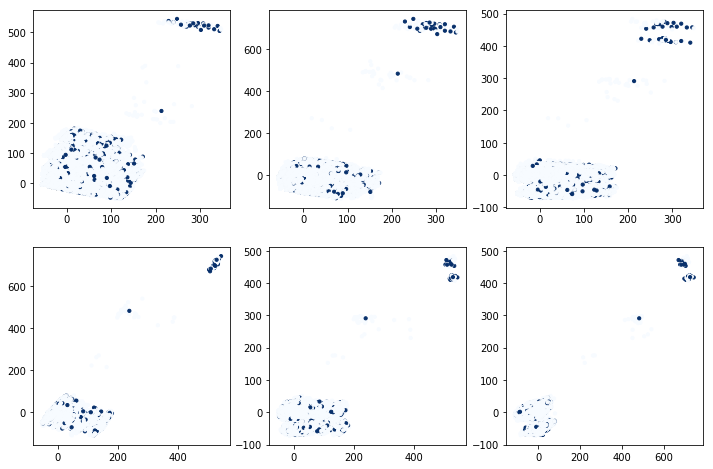

In [19]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 8))
ax1.scatter(Xpca[:, 0], Xpca[:, 1], c=y, cmap=cm.Blues, s=10)
ax2.scatter(Xpca[:, 0], Xpca[:, 2], c=y, cmap=cm.Blues, s=10)
ax3.scatter(Xpca[:, 0], Xpca[:, 3], c=y, cmap=cm.Blues, s=10)
ax4.scatter(Xpca[:, 1], Xpca[:, 2], c=y, cmap=cm.Blues, s=10)
ax5.scatter(Xpca[:, 1], Xpca[:, 3], c=y, cmap=cm.Blues, s=10)
ax6.scatter(Xpca[:, 2], Xpca[:, 3], c=y, cmap=cm.Blues, s=10)

In [20]:
pca.explained_variance_ratio_

array([  2.18662510e-01,   1.13545321e-01,   9.29578770e-02,
         8.46166784e-02,   7.36652210e-02,   5.89661500e-02,
         5.53094222e-02,   4.97154552e-02,   4.07991690e-02,
         3.67162142e-02,   3.46418838e-02,   2.87026706e-02,
         2.54575340e-02,   2.40797102e-02,   1.80598572e-02,
         1.31401138e-02,   8.41522741e-03,   7.05226654e-03,
         3.07105263e-03,   2.10324920e-03,   1.61289873e-03,
         1.44221934e-03,   1.25817241e-03,   1.04041889e-03,
         5.83309592e-04,   5.49172437e-04,   4.07338194e-04,
         3.82518014e-04,   3.40393521e-04,   3.15936773e-04,
         3.06010837e-04,   2.97246359e-04,   2.76617857e-04,
         2.46241077e-04,   2.38611982e-04,   1.83624111e-04,
         1.62561432e-04,   1.53676152e-04,   1.27641221e-04,
         1.14574309e-04,   7.94831042e-05,   5.45805465e-05,
         2.29817182e-05,   1.99082287e-05,   1.96645467e-05,
         1.58060680e-05,   1.57743657e-05,   1.56882951e-05,
         1.54194339e-05,

<Container object of 56 artists>

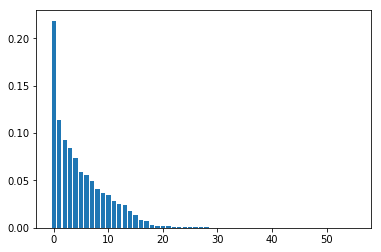

In [21]:
plt.bar(range(Xpca.shape[1]), pca.explained_variance_ratio_)

Gini=0.234+/-0.010, Best=0.242
CPU times: user 5min 43s, sys: 645 ms, total: 5min 44s
Wall time: 46.5 s


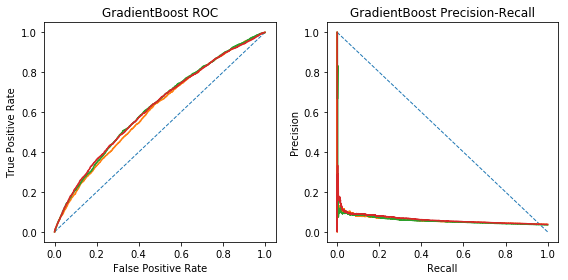

In [40]:
%%time
fig = plt.figure(figsize=(8, 4))
ax21 = fig.add_subplot(1, 2, 1)
ax22 = fig.add_subplot(1, 2, 2)

neutral_line = np.linspace(0, 1, 10)
ax21.plot(neutral_line, neutral_line, lw=1, ls='--')
ax22.plot(neutral_line, 1- neutral_line, lw=1, ls='--')

ginis_xgb = []

for i in range(3):

    rstate = None
    X_train, X_test, y_train, y_test = train_test_split(Xpca[:, :-2], y, test_size=0.1, random_state=rstate)

    num_class1 = np.sum(y_train)
    num_class1_to_resample = 2 * num_class1
    num_class0_to_resample = int(1 * num_class1_to_resample)

    # First, randomly undersample the majority
    rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
    X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

    # Then use SMOTE to oversample the minority
    smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=8)
    X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

    # GradientBoost
    clf = RandomForestClassifier(n_estimators=200, max_depth=10, n_jobs=8)
    clf.fit(X_res, y_res)

    y_pred2 = clf.predict(X_test)
    y_proba2 = clf.predict_proba(X_test)
    ginis_xgb.append(my_gini(y_test, y_proba2))
    report2 = classification_report(y_test, y_pred2, digits=4,
                                   labels=None, target_names=None)

    precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
    fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
    ax21.plot(fpr2, tpr2)
    ax21.set_xlabel('False Positive Rate')
    ax21.set_ylabel('True Positive Rate')
    ax21.set_title('GradientBoost ROC')
    ax22.plot(recall2, precision2)
    ax22.set_xlabel('Recall')
    ax22.set_ylabel('Precision')
    ax22.set_title('GradientBoost Precision-Recall')

plt.tight_layout()

print('Gini=%.3f+/-%.3f, Best=%.3f' % (np.mean(ginis_xgb), np.std(ginis_xgb), np.max(ginis_xgb)))

In [42]:
100*clf.feature_importances_#[52]

array([  5.82932374,   2.69191977,   0.70950839,   1.51164446,
         0.74407314,   1.03415683,   0.98069826,   1.00460399,
         0.8569485 ,   0.85172717,   0.62024371,   0.59366512,
         0.60634373,   0.58564012,   0.54220051,   0.51404684,
         0.53379624,   0.58380463,   0.57872613,   0.56627025,
         0.69699892,   0.6521166 ,   0.65445181,   0.68326753,
         0.56667263,   1.8525719 ,   1.32293787,   1.45960995,
         3.05951276,   0.76021658,   0.65879359,   3.12504504,
         4.08293277,   3.21247185,   2.59180245,   0.68330855,
         1.74908361,  11.01076721,   1.04819487,   0.76708319,
         0.73284827,   0.66004722,   0.6678459 ,   0.97402081,
         7.61953959,   0.54499262,   0.59864273,   0.62146609,
         4.66179473,   3.85568977,   0.68703335,   0.56117483,
        14.70795953,   0.52976336])

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
%%time
fig = plt.figure(figsize=(8, 4))
ax21 = fig.add_subplot(1, 2, 1)
ax22 = fig.add_subplot(1, 2, 2)

neutral_line = np.linspace(0, 1, 10)
ax21.plot(neutral_line, neutral_line, lw=1, ls='--')
ax22.plot(neutral_line, 1- neutral_line, lw=1, ls='--')

ginis_xgb = []

for i in range(5):

    rstate = None
    X_train, X_test, y_train, y_test = train_test_split(Xpca, y, test_size=0.1, random_state=rstate)

    num_class1 = np.sum(y_train)
    num_class1_to_resample = 2 * num_class1
    num_class0_to_resample = int(1 * num_class1_to_resample)

    # First, randomly undersample the majority
    rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
    X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

    # Then use SMOTE to oversample the minority
    smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=8)
    X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

    # GradientBoost
    clf = LogisticRegression(C=1e4, penalty='l1')
    clf.fit(X_res, y_res)

    y_pred2 = clf.predict(X_test)
    y_proba2 = clf.predict_proba(X_test)
    ginis_xgb.append(my_gini(y_test, y_proba2))
    report2 = classification_report(y_test, y_pred2, digits=4,
                                   labels=None, target_names=None)

    precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
    fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
    ax21.plot(fpr2, tpr2)
    ax21.set_xlabel('False Positive Rate')
    ax21.set_ylabel('True Positive Rate')
    ax21.set_title('GradientBoost ROC')
    ax22.plot(recall2, precision2)
    ax22.set_xlabel('Recall')
    ax22.set_ylabel('Precision')
    ax22.set_title('GradientBoost Precision-Recall')

plt.tight_layout()

print('Gini=%.3f+/-%.3f, Best=%.3f' % (np.mean(ginis_xgb), np.std(ginis_xgb), np.max(ginis_xgb)))

In [ ]:
%%time
fig = plt.figure(figsize=(8, 4))
ax21 = fig.add_subplot(1, 2, 1)
ax22 = fig.add_subplot(1, 2, 2)

neutral_line = np.linspace(0, 1, 10)
ax21.plot(neutral_line, neutral_line, lw=1, ls='--')
ax22.plot(neutral_line, 1- neutral_line, lw=1, ls='--')

ginis_xgb = []

for i in range(5):

    rstate = None
    X_train, X_test, y_train, y_test = train_test_split(Xpca, y, test_size=0.1, random_state=rstate)

    num_class1 = np.sum(y_train)
    num_class1_to_resample = 2 * num_class1
    num_class0_to_resample = int(1 * num_class1_to_resample)

    # First, randomly undersample the majority
    rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
    X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

    # Then use SMOTE to oversample the minority
    smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=8)
    X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

    # GradientBoost
    clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=9, learning_rate=0.05, max_delta_step=0,
       max_depth=11, min_child_weight=4, missing=None, n_estimators=200,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.85)
    clf.fit(X_res, y_res)

    y_pred2 = clf.predict(X_test)
    y_proba2 = clf.predict_proba(X_test)
    ginis_xgb.append(my_gini(y_test, y_proba2))
    report2 = classification_report(y_test, y_pred2, digits=4,
                                   labels=None, target_names=None)

    precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
    fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
    ax21.plot(fpr2, tpr2)
    ax21.set_xlabel('False Positive Rate')
    ax21.set_ylabel('True Positive Rate')
    ax21.set_title('GradientBoost ROC')
    ax22.plot(recall2, precision2)
    ax22.set_xlabel('Recall')
    ax22.set_ylabel('Precision')
    ax22.set_title('GradientBoost Precision-Recall')

plt.tight_layout()

print('Gini=%.3f+/-%.3f, Best=%.3f' % (np.mean(ginis_xgb), np.std(ginis_xgb), np.max(ginis_xgb)))